# TransLeish _In Vivo_ study analysis

We want to extract cell line barcodes from sequencing samples, count their unique occurrances and infer the cell line fitnesses.

We need to load a set of libraries for this:
 * `matplotlib`: a plotting library
 * `numpy`: python extension to work with large numerical arrays
 * `pandas`: data analysis tool to work with large spreadsheet-like data sets
 * `scipy`: library that includes many scientific data analysis methods (we use it here for the statistics)
 * `tqdm`: tool to display a progress bar

We are also using a few python internal libraries:
 * `re`: library to work with regular expressions (mainly used for the analysis of text)
 * `pathlib`: library to handle paths to directories and files
 * `json`: library to load and save structured data
 * `urllib.request`: library to load data from URLs

Finally, we use the internally-developed library `LeishFASTQ` to extract the unique barcodes from our sequenceing FASTQ files.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
idx = pd.IndexSlice
from scipy.stats import mannwhitneyu

from tqdm.auto import tqdm

import re
import pathlib
import json
from urllib.request import urlopen, urlretrieve
from urllib.parse import quote

from LeishFASTQ.leishfastq import process_fastq_files


First we define the names for the assays and normalise the abbreviations:

In [2]:
assaynames = {
    'MasterPool_iPSC': 'IMAC',
    'Mice_Control': 'FP',
    'Mice_FPAD': 'FP',
}

Next, let us find the list of samples and URLs to the FASTQ files from the ENA. This essentially queries the ENA for the TransLeish project accession number and extracts all samples that start with the assay names above. We then use this to construct a list of samples with the corresponding forward and reverse read FASTQ file URLs.

In [3]:
query = 'study_accession="PRJEB76744" AND (' + ' OR '.join([f'sample_title="*{name}*"' for name in assaynames.keys()]) + ')'
query

'study_accession="PRJEB76744" AND (sample_title="*MasterPool_iPSC*" OR sample_title="*Mice_Control*" OR sample_title="*Mice_FPAD*")'

In [4]:
with urlopen(f'https://www.ebi.ac.uk/ena/portal/api/search?result=read_run&query={quote(query)}&fields=fastq_ftp%2Csample_title&format=json') as f:
    content = f.read()

runs = (
    pd.DataFrame(json.loads(content.decode('ascii')))
    .set_index('sample_title')
    .fastq_ftp.str.split(';', expand=True)
    .rename(columns=lambda x: str(x + 1))
    .rename_axis('direction', axis=1)
    .stack()
)
runs

sample_title            direction
MasterPool_iPSC_1_120h  1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/003/ERR132...
                        2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/003/ERR132...
MasterPool_iPSC_1_3h    1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/006/ERR132...
                        2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/006/ERR132...
MasterPool_iPSC_1_48h   1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/007/ERR132...
                                                           ...                        
Mice_FPAD_2_72h         2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/046/ERR132...
Mice_FPAD_5_3W          1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/053/ERR132...
                        2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/053/ERR132...
Mice_FPAD_5_6W          1            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/054/ERR132...
                        2            ftp.sra.ebi.ac.uk/vol1/fastq/ERR132/054/ERR132...
Length: 1

Next, we download the FASTQ files from ENA (unless the files are already present from a previous run, in which case the downloading is skipped).

In [5]:
directory = pathlib.Path('.')
for (sample, direction), url in tqdm(runs.items(), total=runs.shape[0]):
    filename = f"{sample}_R{direction}_.fastq.gz"
    if not (directory / filename).exists():
        urlretrieve("http://" + url, filename=filename)

  0%|          | 0/108 [00:00<?, ?it/s]

We also need to load the database that maps the 17nt barcode sequences to their corresponding IDs.

In [6]:
barcode_database = pd.read_csv('barcode_database.csv').set_index('barcode_sequence')

Now we use the function `process_fastq_files` from the `LeishFASTQ` library to find all barcode sequences in the FASTQ files and compare them to the known sequences in `barcode_database`. This is done by allowing up to two nucleotide substitutions in the flanking sequences, and up to a single substitution in the barcode sequence itself (when comparing to the known barcodes). Please ignore the warning about allowing more than one substition - it safely reduces the number of substitutions to one only in the barcode sequences.

In [7]:
raw_read_counts = process_fastq_files(
    [filename for assayname in assaynames.keys() for filename in pathlib.Path('.').glob(assayname + '*.fastq.gz')],
    allow_substitutions=2,
    nr_workers=1,
    known_sequences=list(barcode_database.index),
    progress_wrap=lambda *a, **kw: tqdm(*a, desc="Finding barcodes", **kw)
)

Finding barcodes:   0%|          | 0/108 [00:00<?, ?it/s]

We next create a long list of barcode sequences and their read counts in each sample. Please note that we simply add the read counts from the forward and reverse reads. Invalid reads that do not have a valid barcode in them are identified by a blank barcode sequence.

In [8]:
def timepoint_to_hours(tp):
    tp = tp.lower()
    if tp[-1] == 'w':
        return int(tp[:-1]) * 24*7
    elif tp[-1] == 'd':
        return int(tp[:-1]) * 24
    elif tp[-1] == 'h':
        return int(tp[:-1])
    raise ValueError(f"Time modifier '{tp[:-1]}' not understood.")

In [9]:
fname_re = re.compile('(?P<sample>[A-Za-z]+_[A-Za-z]+)_(?P<replicate>[1-9])_(?P<time>[0-9]+[hW])_R(?P<fwdrev>[12])_*')
def transform_filename(meta):
    return {
        "assay": assaynames[meta['sample']],
        "replicate": int(meta['replicate']),
        "time": timepoint_to_hours(meta['time']),
        "fwdrev": meta['fwdrev'],
    }

read_counts = (
    pd.concat(
        [
            pd.DataFrame(
                [
                    {'barcode_sequence': seq, 'count': v['count'], 'mismatched': v['mismatched']}
                    for seq, v in counts.items()
                ]
            )
            .assign(**transform_filename(fname_re.match(fname).groupdict()))
            .set_index(['assay', 'time', 'replicate', 'fwdrev', 'barcode_sequence'])
            for fname, counts in raw_read_counts.items()
        ]
    )
    .sort_index()
    .groupby(level=['assay', 'time', 'replicate', 'barcode_sequence'], dropna=False)
    .sum()
    .loc[:, ['count']]
)
read_counts

count
assay time replicate barcode_sequence         
FP    0    1                            135662
                     AAAAAAACCCACGTCGC       1
                     AAAAAAACTCTCTTTTA       1
                     AAAAAAAGACAAGAGCC       1
                     AAAAAAATCGGTATTCT       1
...                                        ...
IMAC  120  6         TTTTTGAACCGCGGATG       1
                     TTTTTGGGTACTTTGAG       1
                     TTTTTGTGTAGTGGGGA       1
                     TTTTTTATGAGTGCTTA       1
                     TTTTTTCGGAAAACTCG       1

[834259 rows x 1 columns]

Now we need to load the list of cell line barcode IDs that actually were put through the experiment.

In [10]:
membership = pd.read_csv('invivo_membership.csv').assign(inpool=1).set_index('barcode').inpool

We next lay out the data frame into a wide format with time points and samples, and include the membership "inpool" information above.

In [23]:
timepoints = (
    read_counts
    .unstack(['assay', 'time', 'replicate'], fill_value=0)
    .loc[:, 'count']
    .join(barcode_database.barcode.rename(('barcode', '', ''), ))
    .join(
        membership.rename(('inpool', '', '')),
        on='barcode',
        how='outer',
    )
    .rename_axis('barcode_sequence')
)
timepoints.loc[:, 'inpool'] = timepoints.loc[:, 'inpool'] == 1.0
timepoints.loc[timepoints.loc[:, 'barcode'].isna(), 'barcode'] = ''
timepoints = timepoints.fillna(0.0).set_index(['barcode', 'inpool'], append=True)
timepoints = timepoints.astype(int)
timepoints = timepoints.rename_axis(columns=['assay', 'time', 'replicate'])
filtered_timepoints = timepoints.loc[(timepoints > 10).any(axis=1)].sort_index(level=['inpool', 'barcode', 'barcode_sequence'], ascending=False).sort_index(axis=1)
filtered_timepoints

assay                                 FP                                  \
time                                 0                                     
replicate                              1       2       3       4       5   
barcode_sequence  barcode inpool                                           
AGTTGGCGGGCTGTTTT B999    True      1152    1572    1149    2277    2786   
AGCCTCACGCGGAATCT B9988   True       401     544     451     784     906   
GTCCGTATCTTACTTCA B9927   True      2627    3679    2774    6087    6399   
GACTGGTTTGGAACTGG B9918   True      1969    2772    2246    4454    4933   
AGTCTTCGCAAAGCTCA B99     True       179     279     258     494     515   
...                                  ...     ...     ...     ...     ...   
AACCCAATACACACGAC         False        2       2       0       1       3   
AACCCAAAACCCACGAC         False        0       1       0       2       1   
AACCCAAAACCCACCAT         False        1       0       1       0       2   
AACCAAATACCCACGAC         False        1       2       0       2       0   
                          False   135662  193536  131556  276773  264993   

assay                                                               ...  \
time                                       72                       ...   
replicate                              6     1     2     3       4  ...   
barcode_sequence  barcode inpool                                    ...   
AGTTGGCGGGCTGTTTT B999    True      2125    15     2     9    1953  ...   
AGCCTCACGCGGAATCT B9988   True       677     0     0     4       0  ...   
GTCCGTATCTTACTTCA B9927   True      4660    12     8     7    2461  ...   
GACTGGTTTGGAACTGG B9918   True      3566    10     5     9    1793  ...   
AGTCTTCGCAAAGCTCA B99     True       286     0     1     0     186  ...   
...                                  ...   ...   ...   ...     ...  ...   
AACCCAATACACACGAC         False        1     0     0     0       0  ...   
AACCCAAAACCCACGAC         False        2     0     0     0       0  ...   
AACCCAAAACCCACCAT         False        0     0     0     0       0  ...   
AACCAAATACCCACGAC         False        0     0     0     0       0  ...   
                          False   202963  6036  1706  3070  128755  ...   

assay                               IMAC                                  \
time                                 48                              120   
replicate                              3       4       5       6       1   
barcode_sequence  barcode inpool                                           
AGTTGGCGGGCTGTTTT B999    True       599     209     455     859    1144   
AGCCTCACGCGGAATCT B9988   True       421     137     206     458      75   
GTCCGTATCTTACTTCA B9927   True      1865     607     913    1953    2645   
GACTGGTTTGGAACTGG B9918   True      1326     393     817    1362    1845   
AGTCTTCGCAAAGCTCA B99     True       122      31      38      38     108   
...                                  ...     ...     ...     ...     ...   
AACCCAATACACACGAC         False        0       0       0       0       0   
AACCCAAAACCCACGAC         False        0       0       0       0       1   
AACCCAAAACCCACCAT         False        0       0       0       1       1   
AACCAAATACCCACGAC         False        0       0       0       0       0   
                          False   295633  502296  304869  434562  355841   

assay                                                                     
time                                                                      
replicate                              2       3       4       5       6  
barcode_sequence  barcode inpool                                          
AGTTGGCGGGCTGTTTT B999    True       542     760     515     272     446  
AGCCTCACGCGGAATCT B9988   True        41      73      50      15      47  
GTCCGTATCTTACTTCA B9927   True      1159    1538    1106     704    1111  
GACTGGTTTGGAACTGG B9918   True       901    1037     892     487   

We provide a summary, as in how many reads were from expected barcodes (in the pool), how many were foreign to the pool, how many reads were invalid, etc.

In [16]:
def count(g):
    return (g>0).sum()
summary = timepoints.groupby([timepoints.index.get_level_values('barcode_sequence') != '', timepoints.index.get_level_values('barcode') != '', timepoints.index.get_level_values('inpool')]).agg(['sum', count]).sort_index(axis=1).rename({'count': 'unique_barcodes', 'sum': 'total_counts'}, axis=1).reorder_levels([3, 0, 1, 2], axis=1)
summary = summary[summary.sum(axis=1) > 0]
summary.sort_index(axis=1, inplace=True)
summary.index = pd.Series(['invalid_reads', 'unknown_sequences', 'foreign_barcodes', 'pool_members'])
summary

total_counts                                                \
assay                       FP                                                 
time                       0                                             72    
replicate                    1       2       3       4       5       6     1   
invalid_reads           135662  193536  131556  276773  264993  202963  6036   
unknown_sequences        27233   43615   28274   63892   45764   39724  2774   
foreign_barcodes          1448    2210     457    1545     299     125    45   
pool_members            416285  577875  431617  871658  935684  731908  2117   

                                       ... unique_barcodes                     \
assay                                  ...            IMAC                      
time                                   ...             48                       
replicate             2     3       4  ...               3     4     5      6   
invalid_reads      1706  3070  128755  ...               1     1     1      1   
unknown_sequences  1007  1204   27121  ...           12404  5843  8023  16149   
foreign_barcodes     57    21     266  ...              28    25    19     35   
pool_members        962  2547  447398  ...             329   328   328    330   

                                                            
assay                                                       
time                 120                                    
replicate              1      2      3      4     5      6  
invalid_reads          1      1      1      1     1      1  
unknown_sequences  18682  11736  14606  11128  6382  12762  
foreign_barcodes      40     45     38     41    38     42  
pool_members         328    328    327    327   325    328  

[4 rows x 108 columns]

The graph below shows the number of read counts in each sample, split up in the following categories:
* Pool members - these are read counts from expected cell lines
* Foreign barcodes - these are read counts from cell lines for which the barcode sequence is known, but which weren't present in the experiment. If we had a lot of these foreign barcodes, we clearly had an issue during e.g. sample preparation.
* Unknown sequences - these reads have valid flanking sequences and a barcode sequence of the correct length, but the barcode sequence itself is not associated with any known cell line.
* Invalid reads - these are reads that have missing or mangled flanking sequences or a barcode sequence of an incorrect length.

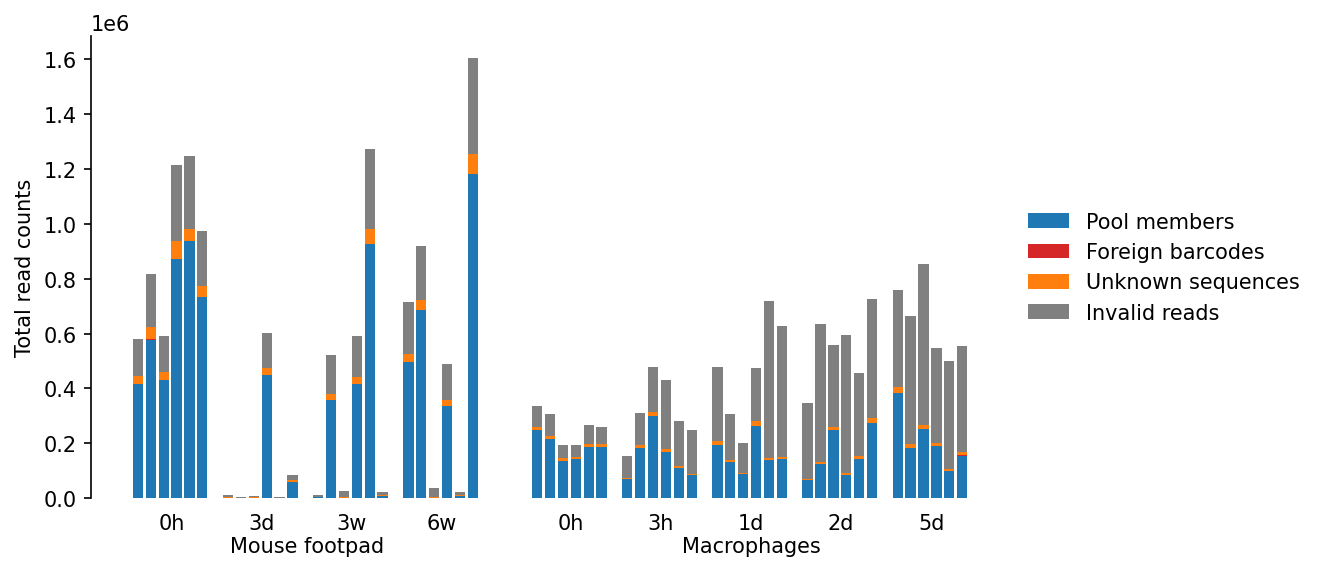

In [25]:
assaylabels = {
    "FP": "Mouse footpad",
    "IMAC": "Macrophages",
}

def draw_summary_figure(
        data,
        include_fields = {
            "pool_members": ("Pool members", 'C0'),
            "foreign_barcodes": ("Foreign barcodes", 'C3'),
            "unknown_sequences": ("Unknown sequences", 'C1'),
            "invalid_reads": ("Invalid reads", 'grey'),
        },
        yaxis_label="Total read counts",
    ):
    fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=150)
    fig.subplots_adjust(left=0.07, right=0.75)

    samples = data.columns.to_frame().droplevel("replicate")

    def leavespace(amount):
        def f(s):
            space = s.copy()
            space.iloc[0] += amount
            return space
        return f
    x = pd.Series(np.ones(samples.shape[0]), index=samples.index)
    levels = []
    for i, level in enumerate(samples.index.names):
        levels.append(level)
        amount = 2*(len(samples.index.names)-i-1)+1
        x = x.groupby(level=levels).transform(leavespace(amount))
    x = x.cumsum()
    x -= x.iloc[0]
    samples.loc[:, "x"] = x
    bottom = 0
    for field, (label, colour) in include_fields.items():
        ax.bar(x, data.loc[field, :], bottom=bottom, label=label, color=colour, align='edge')
        bottom = bottom + data.loc[field, :]
    ax.spines[['bottom', 'top', 'right']].set_visible(False)

    def human_readable_time(hours):
        if hours >= 7*24:  # week
            return str(hours // (7*24)) + "w"
        elif hours >= 24:  # day
            return str(hours // 24) + "d"
        else:
            return str(hours) + "h"
    levels = []
    for i, level in enumerate(samples.index.names):
        levels.append(level)
        tx = ax.twiny()
        tx.spines['bottom'].set_position(('axes', -0.05*(len(samples.index.names) - 1 - i)))
        tx.spines[['left', 'bottom', 'top', 'right']].set_visible(False)
        locations = samples.groupby(level=levels).x.mean() + 0.5

        labels = locations.index.get_level_values(level)
        if level == "time":
            labels = [human_readable_time(hours) for hours in labels]
        labels = [assaylabels[lbl] if lbl in assaylabels else lbl for lbl in labels]
        tx.axis(ax.axis())
        tx.tick_params("x", which="both", top=False, bottom=False, labeltop=False, labelbottom=True)
        tx.set_xticks(locations, labels)
    ax.set_xticks([])
    ax.set_ylabel(yaxis_label)
    ax.legend(frameon=False, ncols=1, loc="center left", bbox_to_anchor=(1, 0.5))

draw_summary_figure(summary.loc[:, "total_counts"])

Finally, we calculate the fitness of each cell line (which essentially is the read out effect size of our experiments) and the statistical p-value. This is done by calculating how much each cell line changed between the 0h and 24h time points. We then compare the change of each cell line to the median change of the included parental cell lines to find the fitness (effect size). We determine the p value by calculating the Mann Whitney U test for between the cell line replicates and the parental replicates.  

In [21]:
inpool = timepoints.loc[idx[:, :, True]]
inpool = inpool[inpool.index.get_level_values('barcode_sequence').notna()]
inpool = inpool.stack(['assay', 'time'])
def relzero(g):
    times = [t for t in g.index.get_level_values('time') if t != 0]
    other = g.loc[idx[:, :, :, times], :]
    zero = g.loc[idx[:, :, :, 0], :].droplevel('time')
    return other / zero
inpool = inpool.groupby(['assay', 'barcode'], group_keys=False).apply(relzero)
inpool = inpool.fillna(0)
def stats(g):
    parentals = g.loc[idx[:, ['B87', 'B88', 'B89', 'B90', 'B91']], :].stack()
    pmedian = parentals.median()
    ret = pd.DataFrame({
        "pvalue": [mannwhitneyu([v for v in r if np.isfinite(v)], parentals).pvalue for _, r in g.iterrows()],
        "effectsize": g.median(axis=1)/pmedian
    }, index=g.index)
    return ret
statistics = (inpool
    .groupby(["assay", "time"], group_keys=False).apply(stats)
    .sort_index()
    .droplevel('barcode_sequence')
    .reorder_levels(['barcode', 'assay', 'time'])
)
statistics

pvalue  effectsize
barcode assay time                      
B8851   FP    72    0.852370    0.793488
              504   0.547691    2.229277
              1008  0.216582    2.333264
        IMAC  3     0.884935    0.958870
              24    0.327360    1.119083
...                      ...         ...
B95     FP    1008  0.788022    0.579210
        IMAC  3     0.604533    0.723100
              24    0.417604    0.929423
              48    0.575807    0.944252
              120   0.417604    0.798335

[2310 rows x 2 columns]

Finally, we write our results to a large Excel file containing the summary, the read counts, the statistics and the membership information.

In [24]:
with pd.ExcelWriter('TransLeish1_InVivo_results.xlsx') as writer:
    summary.to_excel(writer, sheet_name='Summary')
    filtered_timepoints.to_excel(writer, sheet_name='Read counts')
    statistics.to_excel(writer, sheet_name='Statistics')
    membership.to_frame('inpool').loc[:, []].join(barcode_database.reset_index().set_index('barcode')).sort_values('geneid').to_excel(writer, 'Pool membership')